In [1]:
import scipy
from sklearn import linear_model, metrics
from scipy import stats
import pandas as pd
import os
import random
import multiprocessing
import pickle
from tqdm import tqdm
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
from photutils import CircularAnnulus

from apelfei.utils.data_handling import open_fits
from apelfei.utils.general import center_subpixel

## Set the global colors

In [2]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1],
                 sns.color_palette("colorblind")[3],
                 sns.color_palette("colorblind")[4],
                 sns.color_palette("colorblind")[9]]

#color_palette = sns.color_palette("hls", 5)
color_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Evaluate number of pixel and independent resolution elements

In [3]:
num_res_elements = dict()

for i in np.linspace(1, 8, 15):
    num_res_elements[i] = int(np.floor(np.pi*2*i))

## Run Monte Carlo Simulation - Independent

In [4]:
np.random.seed(42)
num_tests= 1000000

p_values_normal = dict()
p_values_laplace = dict()

for tmp_separation in np.linspace(1, 8, 15):
    print("Running separation " + str(tmp_separation))
    tmp_num_res = num_res_elements[tmp_separation]
    
    # setup empty lists
    p_values_normal[tmp_separation] = []
    p_values_laplace[tmp_separation] = []
    
    for i in tqdm(range(num_tests)):
        # 1.) Sample a random noise values - gaussian, laplace
        tmp_res_values_normal = np.random.normal(loc=0, scale=1, size=tmp_num_res)
        tmp_res_values_lapalce = np.random.laplace(loc=0, scale=1, size=tmp_num_res)
        
        p_values_normal[tmp_separation].append(
            scipy.stats.shapiro(tmp_res_values_normal).pvalue)
        p_values_laplace[tmp_separation].append(
            scipy.stats.shapiro(tmp_res_values_lapalce).pvalue)

Running separation 1.0


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 343466/1000000 [00:06<00:12, 54391.99it/s]


KeyboardInterrupt: 

## Save the results / Or restore the results

In [4]:
result_dir = "../../../70_results/part1/shapiro_tests/"

In [ ]:
# Save as .pkl
with open(os.path.join(result_dir, 'A1_Shapiro_normal.pickle'), 'wb') as handle:
    pickle.dump(p_values_normal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(result_dir, 'A1_Shapiro_laplace.pickle'), 'wb') as handle:
    pickle.dump(p_values_laplace, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# Load .pkl
with open(os.path.join(result_dir, 'A1_Shapiro_normal.pickle'), 'rb') as handle:
    p_values_normal = pickle.load(handle)
    
with open(os.path.join(result_dir, 'A1_Shapiro_laplace.pickle'), 'rb') as handle:
    p_values_laplace = pickle.load(handle)

## Count the occurance of p-values

In [6]:
normal_p_001 = [np.sum(np.array(p_values) < 0.01) / len(p_values) for p_values in p_values_normal.values()]
laplace_p_001 = [np.sum(np.array(p_values) < 0.01) / len(p_values) for p_values in p_values_laplace.values()]

normal_p_02 = [np.sum(np.array(p_values) < 0.2) / len(p_values) for p_values in p_values_normal.values()]
laplace_p_02 = [np.sum(np.array(p_values) < 0.2) / len(p_values) for p_values in p_values_laplace.values()]

## Make the Plot

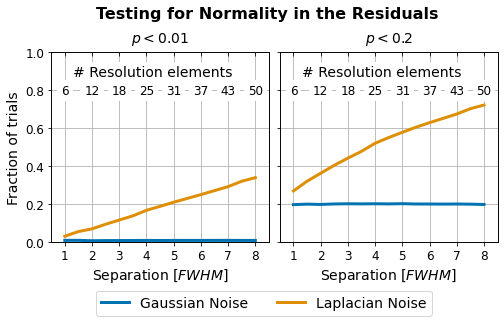

In [7]:
fig = plt.figure(constrained_layout=False, figsize=(8, 3.5))

gs0 = fig.add_gridspec(1, 2)
gs0.update(hspace=0.1, wspace=0.05)

low = fig.add_subplot(gs0[0, 0])
high = fig.add_subplot(gs0[0, 1], sharey=low, sharex=low)

# Plot 1: Low T1 error
low.plot(p_values_normal.keys(), normal_p_001, lw=3, color=color_palette[0], 
            label="Gaussian Noise")
low.plot(p_values_normal.keys(), laplace_p_001, lw=3, color=color_palette[1], 
            label="Laplacian Noise")
low.grid()
low.set_ylim(0, 1)
low.set_xlim(0.5, 8.5)
low.set_xticks(np.arange(1,9))

for tick in low.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in low.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

# second x axis
low_2 = low.twiny()
low_2.set_xticks(np.arange(1, 9))
low_2.tick_params(axis="x",direction="in", pad=-45)
low_2.set_xticklabels(list(num_res_elements.values())[::2], fontsize=12)
low_2.set_xlim(0.5, 8.5)
for tmp_label in low_2.xaxis.get_ticklabels():
    tmp_label.set_bbox(dict(facecolor='white', edgecolor='none'))
low_2.text(1.3, 0.87, "# Resolution elements", 
             bbox=dict(facecolor='white', edgecolor='none'),
             fontsize=14) 

low.set_title(r"$p < 0.01$", fontsize=14, y=1.02)
low.set_xlabel(r"Separation $[FWHM]$", fontsize=14)
low.set_ylabel("Fraction of trials", fontsize=14)


# Plot 3: High T1 error - independent samples
high.plot(p_values_normal.keys(), normal_p_02, lw=3, color=color_palette[0])
high.plot(p_values_normal.keys(), laplace_p_02, lw=3, color=color_palette[1])
high.grid()

plt.setp(high.get_yticklabels(), visible=False)
high.set_title(r"$p < 0.2$", fontsize=14, y=1.02)
for tick in high.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# second x axis
high_2 = high.twiny()
high_2.set_xticks(np.arange(1, 9))
high_2.tick_params(axis="x",direction="in", pad=-45)
high_2.set_xticklabels(list(num_res_elements.values())[::2], fontsize=12)
high_2.set_xlim(0.5, 8.5)
for tmp_label in high_2.xaxis.get_ticklabels():
    tmp_label.set_bbox(dict(facecolor='white', edgecolor='none'))
high_2.text(1.3, 0.87, "# Resolution elements",
              bbox=dict(facecolor='white', edgecolor='none'),
              fontsize=14)


high.set_xlabel(r"Separation $[FWHM]$", fontsize=14)


# Legend
lgd = low.legend(loc='center right',ncol=2,
                 bbox_to_anchor=(1.78, -0.32),
                 fontsize=14,
                 markerscale=3.,)

fig_title = fig.suptitle("Testing for Normality in the Residuals", size=16, fontweight="bold", y=1.06)

fig.patch.set_facecolor('white')
plt.savefig("./14_Residual_Shapiro.pdf", bbox_extra_artists=(lgd, fig_title), bbox_inches='tight')